In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
training_data = pd.read_csv('../data/train.csv')
x_train = training_data['word'].to_list()
y_train = training_data['label'].to_list()

testing_data = pd.read_csv('../data/more_data.csv')
x_test = testing_data['word'].to_list()
y_test = testing_data['label'].to_list()

In [169]:
def find_accuracy(prediction, actual):
    return (np.array(prediction) == np.array(actual)).mean()

## First approach

In [170]:
def classify(train_words, train_labels, test_words):
    return np.random.choice(['french', 'spanish'], len(test_words))

result = classify(x_train, y_train, x_test)
find_accuracy(result, y_test)

0.4980070519699525

## Second Approach (naive base, with ngram_1 feature enginnering)

In [171]:
def making_frequency_dict(df, cols):
    freq_dict = {}
    for col in cols:
        whole_set = df[col].explode().value_counts().index
        for val in whole_set:
            freq_dict[val] = df[col].apply(lambda x: val in x).sum()
    return freq_dict


def find_ngram(word, n):
    return [word[i : i + n] for i in range(len(word) - n + 1)]

def classify(train_words, train_labels, test_words):
    # model training
    training_data = pd.DataFrame({
        'words': train_words,
        'label': train_labels
    })
    
    for i in range(1):
        training_data[f"n{i+1}_gram"] = training_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )

    only_french_train = training_data[training_data["label"] == "french"]
    only_spanish_train = training_data[training_data["label"] == "spanish"]

    french_frequency_dict = making_frequency_dict(
        only_french_train, ["n1_gram"]
    )
    spanish_frequency_dict = making_frequency_dict(
        only_spanish_train, ["n1_gram"]
    )
    total_french_words = only_french_train.shape[0]
    total_spanish_words = only_spanish_train.shape[0]
    french_prop = total_french_words / len(train_words)
    spanish_prop = 1 - french_prop

    # feature transform for the test_words
    testing_data = pd.DataFrame(test_words, columns=["words"])

    for i in range(1):
        testing_data[f"n{i+1}_gram"] = testing_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )

    featured_testing_data = testing_data.assign(
        features=testing_data[["n1_gram"]].apply(
            lambda row: sum([col for col in row], []), axis=1
        )
    )[["words", "features"]]

    def caluclate_french_naive_base(df):
        frequency_prop = {
            key: value / total_french_words
            for key, value in french_frequency_dict.items()
        }
        return df["features"].apply(
            lambda features: french_prop
            * np.prod(
                [
                    (
                        frequency_prop[feature]
                        if feature in frequency_prop.keys()
                        else 0.001
                    )
                    for feature in features
                ]
            )
        )

    def caluclate_spanish_naive_base(df):
        frequency_prop = {
            key: value / total_spanish_words
            for key, value in spanish_frequency_dict.items()
        }
        return df["features"].apply(
            lambda features: spanish_prop
            * np.prod(
                [
                    (
                        frequency_prop[feature]
                        if feature in frequency_prop.keys()
                        else 0.001
                    )
                    for feature in features
                ]
            )
        )

    predictions = featured_testing_data.assign(
        french_naiveBase=caluclate_french_naive_base(featured_testing_data)
    )
    predictions = predictions.assign(
        spanish_naiveBase=caluclate_spanish_naive_base(featured_testing_data)
    )

    results = predictions.apply(
        lambda row: row["french_naiveBase"] > row["spanish_naiveBase"], axis=1
    ).tolist()

    return ["french" if result else "spanish" for result in results]


In [172]:
result = classify(x_train, y_train, x_test)
find_accuracy(result, y_test)

0.6792886708569676

## Third Approach 

In [173]:
def find_ngram(word, n):
    return [word[i : i + n] for i in range(len(word) - n + 1)]


def freq_ending_gram_prop(df, n):
    temp = df.assign(ending=df["words"].apply(lambda x: x[-n:]))

    whole_set = (temp["ending"].value_counts() / temp.shape[0]).to_dict()
    return whole_set


def classify(train_words, train_labels, test_words):
    # model training
    training_data = pd.DataFrame({"words": train_words, "label": train_labels})
    for i in range(1):
        training_data[f"n{i+1}_gram"] = training_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )

    only_french_train = training_data[training_data["label"] == "french"]
    only_spanish_train = training_data[training_data["label"] == "spanish"]

    french_frequency_dict = making_frequency_dict(
        only_french_train, ["n1_gram"]
    )
    spanish_frequency_dict = making_frequency_dict(
        only_spanish_train, ["n1_gram"]
    )

    french_ending_n1_dict = freq_ending_gram_prop(only_french_train, 1)
    spanish_ending_n1_dict = freq_ending_gram_prop(only_spanish_train, 1)

    total_french_words = only_french_train.shape[0]
    total_spanish_words = only_spanish_train.shape[0]
    french_prop = total_french_words / len(train_words)
    spanish_prop = 1 - french_prop

    # feature transform for the test_words
    testing_data = pd.DataFrame({"words": test_words})

    # find all ngrams and turn them into feature
    for i in range(1):
        testing_data[f"n{i+1}_gram"] = testing_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )
    featured_testing_data = testing_data.assign(
        features=testing_data[["n1_gram"]].apply(
            lambda row: sum([col for col in row], []), axis=1
        )
    )[["words", "features"]]

    # finding the ending character and last two ending words

    featured_testing_data["ending_char"] = featured_testing_data["words"].apply(
        lambda x: x[-1]
    )

    def caluclate_french_naive_base(df):
        frequency_prop = {
            key: value / total_french_words
            for key, value in french_frequency_dict.items()
        }
        return (
            df["features"].apply(
                lambda features: french_prop
                * np.prod(
                    [
                        (
                            frequency_prop[feature] + 0.001
                            if feature in frequency_prop.keys()
                            else 0.001
                        )
                        for feature in features
                    ]
                )
            )
            * df["ending_char"].apply(
                lambda ending_char: (
                    french_ending_n1_dict[ending_char] + 0.001
                    if ending_char in french_ending_n1_dict.keys()
                    else 0.001
                )
            )
        )

    def caluclate_spanish_naive_base(df):
        frequency_prop = {
            key: value / total_spanish_words
            for key, value in spanish_frequency_dict.items()
        }
        return (
            df["features"].apply(
                lambda features: spanish_prop
                * np.prod(
                    [
                        (
                            frequency_prop[feature] + 0.001
                            if feature in frequency_prop.keys()
                            else 0.001
                        )
                        for feature in features
                    ]
                )
            )
            * df["ending_char"].apply(
                lambda ending_char: (
                    spanish_ending_n1_dict[ending_char] + 0.001
                    if ending_char in spanish_ending_n1_dict.keys()
                    else 0.001
                )
            )
        )

    predictions = featured_testing_data.assign(
        french_naiveBase=caluclate_french_naive_base(featured_testing_data)
    )
    predictions = predictions.assign(
        spanish_naiveBase=caluclate_spanish_naive_base(featured_testing_data)
    )

    results = predictions.apply(
        lambda row: row["french_naiveBase"] > row["spanish_naiveBase"], axis=1
    ).tolist()

    return ["french" if result else "spanish" for result in results]

In [174]:
result = classify(x_train, y_train, x_test)
find_accuracy(result, y_test)

0.7667484286371301

## Fourth Approach (2ngram)

In [175]:

def making_frequency_dict(df, cols):
    freq_dict = {}
    for col in cols:
        whole_set = df[col].explode().value_counts().index
        for val in whole_set:
            freq_dict[val] = df[col].apply(lambda x: val in x).sum()
    return freq_dict


def find_ngram(word, n):
    return [word[i : i + n] for i in range(len(word) - n + 1)]


def classify(train_words, train_labels, test_words):
    # model training
    training_data = pd.DataFrame({
        'words': train_words,
        'label': train_labels
    })
    
    for i in range(2):
        training_data[f"n{i+1}_gram"] = training_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )

    only_french_train = training_data[training_data["label"] == "french"]
    only_spanish_train = training_data[training_data["label"] == "spanish"]

    french_frequency_dict = making_frequency_dict(
        only_french_train, ["n1_gram", "n2_gram"]
    )
    spanish_frequency_dict = making_frequency_dict(
        only_spanish_train, ["n1_gram", "n2_gram"]
    )
    total_french_words = only_french_train.shape[0]
    total_spanish_words = only_spanish_train.shape[0]
    french_prop = total_french_words / len(train_words)
    spanish_prop = 1 - french_prop

    # feature transform for the test_words
    testing_data = pd.DataFrame(test_words, columns=["words"])

    for i in range(2):
        testing_data[f"n{i+1}_gram"] = testing_data["words"].apply(
            lambda x: find_ngram(x, i + 1)
        )

    featured_testing_data = testing_data.assign(
        features=testing_data[["n1_gram", "n2_gram"]].apply(
            lambda row: sum([col for col in row], []), axis=1
        )
    )[["words", "features"]]

    def caluclate_french_naive_base(df):
        frequency_prop = {
            key: value / total_french_words
            for key, value in french_frequency_dict.items()
        }
        return df["features"].apply(
            lambda features: french_prop
            * np.prod(
                [
                    (
                        frequency_prop[feature]
                        if feature in frequency_prop.keys()
                        else 0.001
                    )
                    for feature in features
                ]
            )
        )

    def caluclate_spanish_naive_base(df):
        frequency_prop = {
            key: value / total_spanish_words
            for key, value in spanish_frequency_dict.items()
        }
        return df["features"].apply(
            lambda features: spanish_prop
            * np.prod(
                [
                    (
                        frequency_prop[feature]
                        if feature in frequency_prop.keys()
                        else 0.001
                    )
                    for feature in features
                ]
            )
        )

    predictions = featured_testing_data.assign(
        french_naiveBase=caluclate_french_naive_base(featured_testing_data)
    )
    predictions = predictions.assign(
        spanish_naiveBase=caluclate_spanish_naive_base(featured_testing_data)
    )

    results = predictions.apply(
        lambda row: row["french_naiveBase"] > row["spanish_naiveBase"], axis=1
    ).tolist()

    return ["french" if result else "spanish" for result in results]


In [176]:
result = classify(x_train, y_train, x_test)
find_accuracy(result, y_test)

0.7756400429250345

In [188]:
def increase_missing_val(df, missing_rate):
    
    df = df.copy()

    spanish_index = df[df['label'] == 'spanish'].index

    nan_count = int(len(spanish_index) * missing_rate)
    nan_indices = np.random.choice(spanish_index, size=nan_count, replace=False)

    df.loc[nan_indices, 'word'] = np.nan

    df = df.dropna()
    x_train = df['word'].to_list()
    y_train = df['label'].to_list()

    return x_train, y_train

x_train, y_train = increase_missing_val(training_data, 0.3)

In [189]:
scoring_table = pd.DataFrame(columns=[ 'accuracy'])
for missing_rate in np.arange(0, 1, 0.1):
    x_train, y_train = increase_missing_val(training_data, missing_rate)
    result = classify(x_train, y_train, x_test)
    scoring_table.loc[missing_rate, 'accuracy'] = find_accuracy(result, y_test)

In [192]:
scoring_table

,accuracy
0.0,0.77564
0.1,0.761996
0.2,0.768511
0.3,0.74337
0.4,0.734018
0.5,0.740074
0.6,0.720451
0.7,0.689407
0.8,0.613368
0.9,0.48053


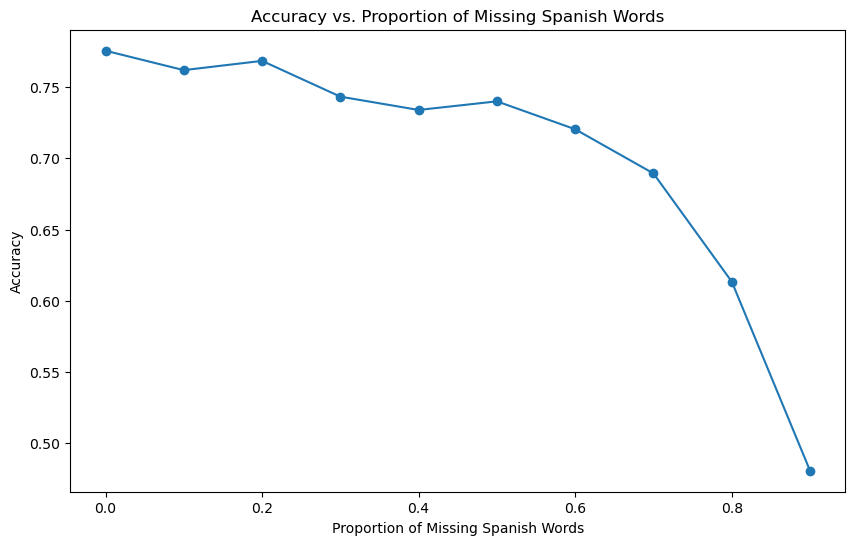

In [194]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(scoring_table.index, scoring_table['accuracy'], marker='o')

# Labeling the plot
plt.xlabel('Proportion of Missing Spanish Words')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Proportion of Missing Spanish Words')

# Display the plot
plt.show()